# Data Re-Uploading on a multi circle data set, with squeezing, RzRxRz circuit order

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

from pennylane.optimize import AdamOptimizer, GradientDescentOptimizer

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import numpy as np


from scipy.sparse.linalg import expm
from scipy.sparse import coo_matrix, csc_matrix, diags, identity


import jax.numpy as jnp
from jax import grad, vmap, jit
from jax import random

import jax

import scipy

from tqdm import tqdm

from sklearn.utils import shuffle

import qutip as q

from tqdm import tqdm

#from bloch_3d_plot import plot_bloch



from sklearn.model_selection import train_test_split



We again first define the spin matrices and the functions that act on a state.

In [2]:
l = 1 # spin length

# let's put together spin matrices
dim_qudit = 2*l+1
qudit_range = np.arange(l, -(l+1),-1)

Id  =  scipy.sparse.csc_matrix(identity(dim_qudit))
Lx  =  scipy.sparse.csc_matrix(1/2*diags([np.sqrt([(l-m+1)*(l+m) for m in qudit_range[:-1]]), np.sqrt([(l+m+1)*(l-m) for m in qudit_range[1:]]) ], [-1, 1]))
Lz  =  scipy.sparse.csc_matrix(diags([qudit_range], [0]))
Lz2 = Lz.multiply(Lz)
Lx2 = Lx.multiply(Lx)

Lx = Lx.toarray()
Lz = Lz.toarray()
Lz2 = Lz2.toarray()


Lx = jnp.array(Lx)
Lz = jnp.array(Lz)
Lz2 = jnp.array(Lz2)

In [3]:
def Rx(psi, theta, conj=False):
    if conj:
        Ux = jax.scipy.linalg.expm(1j*theta*Lx)
    else:
        Ux = jax.scipy.linalg.expm(-1j*theta*Lx)
    psi = jnp.dot(Ux,psi)
    return psi

def Rz(psi, theta, conj=False):
    if conj:
        Uz = jax.scipy.linalg.expm(1j*theta*Lz)
    else:
        Uz = jax.scipy.linalg.expm(-1j*theta*Lz)
    psi = jnp.dot(Uz,psi)
    return psi

def Rz2(psi, theta, conj=False):
    if conj:
        Uz2 = jax.scipy.linalg.expm(1j*theta*Lz2)
    else:
        Uz2 = jax.scipy.linalg.expm(-1j*theta*Lz2)
    psi = jnp.dot(Uz2,psi)
    return psi

def Initialization(psi :np.array, x1: float, x2: float, conj=False)-> np.array:
    psi = Rz(psi, x1)
    return Rx(psi, x2)



In [4]:
state_labels = [[0], [int((2*l+1)//2)], [-1]]

def cost_circ(params, x, y):

    
    loss = 1-circ(params, x, y)**2
    return loss 


def circ(params, x, y):

    psi = 1j*jnp.zeros(int(l*2+1))
    #This is necessary since jnp arrays are immutable
    psi = jax.ops.index_add(psi, 0, 1+1j*0)
    
    label = 1j*jnp.zeros(int(l*2+1))

    label = jax.ops.index_add(label, y, 1+1j*0)
    for i in range(0, len(params)-1):
    
        psi = Initialization(psi, x[0], x[1])
    
        psi = Rz(psi, params[i][0])
        psi = Rx(psi, params[i][1])
        psi = Rz(psi, params[i][2])
        psi = Rz2(psi, params[i][3])
    
    psi = Rx(psi, params[i+1][0])
    psi = Rz(psi, params[i+1][1])
    psi = Rx(psi, params[i+1][2])

    
    return jnp.abs(jnp.dot(psi, label))


def test(params, x, state_labels=state_labels):

    fidelity_values = []
    dm_labels = state_labels
    predicted = []

    
    fidelities = jnp.array([circ(params, x, dm) for dm in dm_labels])
    best_fidel = jnp.argmax(fidelities)
    #print(fidelities, best_fidel)
    

    return best_fidel

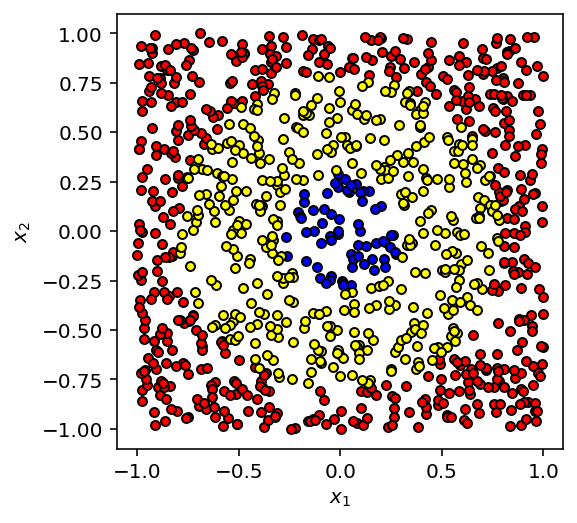

In [5]:
def accuracy_score(y_true, y_pred):

    score = y_true == y_pred
    return score.sum() / len(y_true)


def circle(samples, center=[0.0, 0.0], radius=np.sqrt(2 / np.pi)):

    Xvals, yvals = [], []

    for i in range(samples):
        x = 2 * (np.random.rand(2)) - 1
        y = 0
        if np.linalg.norm(x) < radius and np.linalg.norm(x) >= 0.3:
            y =  (2*l+1)//2
        elif np.linalg.norm(x) < radius:
            y = -1
        Xvals.append(x)
        yvals.append(y)
    return np.array(Xvals), np.array(yvals)




def plot_data(x, y, fig=None, ax=None, title=None):

    if fig == None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    reds = y == 0
    blues = y == -1
    yellows = y == int((2*l+1)//2)
    ax.scatter(x[reds, 0], x[reds, 1], c="red", s=20, edgecolor="k")
    ax.scatter(x[blues, 0], x[blues, 1], c="blue", s=20, edgecolor="k")
    ax.scatter(x[yellows, 0], x[yellows, 1], c="yellow", s=20, edgecolor="k")
    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")
    ax.set_title(title)


Xdata, ydata = circle(1000)
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
plot_data(Xdata, ydata, fig=fig, ax=ax)

def iterate_minibatches(inputs, targets, batch_size):

    for start_idx in range(0, inputs.shape[0] - batch_size + 1, batch_size):
        idxs = slice(start_idx, start_idx + batch_size)
        yield inputs[idxs], targets[idxs]

We then need the gradient of the cost function.

In [6]:
@jit
def vmap_cost(params, X_batched, y_batched):
    return vmap(cost_circ,  in_axes=(None, 0, 0))(params, X_batched, y_batched).sum()/len(X_batched)

@jit
def vmap_cost_ind(params, X_batched, y_batched, beta=0.3):
    return vmap(cost_circ,  in_axes=(None, 0, 0, None, None))(params, X_batched, y_batched, beta, True)

@jit
def vmap_test(params, X_batched, state_labels):
    return vmap(test,  in_axes=(None, 0, None))(params, X_batched, state_labels)


cost_circ_grad = grad(vmap_cost, argnums=0)

In [7]:
state_labels_flat = np.array(state_labels).flatten()

Now we have everything we need and can start learning. We first need to create the dataset and choose random parameters to start.

In [45]:
x_data, y_data = circle(1000)

batch_size = 100

num_layers = 5

num_params = 4

x_data, y_data = shuffle(x_data, y_data)


train_x, test_x, train_y, test_y = train_test_split(x_data, y_data)



--------------------------------------
Starting Learning with 2 layer(s)!
Starting Epoch 1, learning rate: 0.05
Epoch 1, Loss: 0.562, Accuracy: 0.398
Starting Epoch 2, learning rate: 0.05
Epoch 2, Loss: 0.526, Accuracy: 0.490
Starting Epoch 3, learning rate: 0.05
Epoch 3, Loss: 0.505, Accuracy: 0.536
Starting Epoch 4, learning rate: 0.05
Epoch 4, Loss: 0.506, Accuracy: 0.522
Starting Epoch 5, learning rate: 0.05
Epoch 5, Loss: 0.505, Accuracy: 0.534
Starting Epoch 6, learning rate: 0.05
Epoch 6, Loss: 0.505, Accuracy: 0.530
Starting Epoch 7, learning rate: 0.05
Epoch 7, Loss: 0.505, Accuracy: 0.530
Starting Epoch 8, learning rate: 0.05
Epoch 8, Loss: 0.507, Accuracy: 0.534
Starting Epoch 9, learning rate: 0.05
Epoch 9, Loss: 0.505, Accuracy: 0.536
Starting Epoch 10, learning rate: 0.05
Epoch 10, Loss: 0.505, Accuracy: 0.534
Starting Epoch 11, learning rate: 0.05
Epoch 11, Loss: 0.506, Accuracy: 0.530
Starting Epoch 12, learning rate: 0.05
Epoch 12, Loss: 0.505, Accuracy: 0.526
Starting

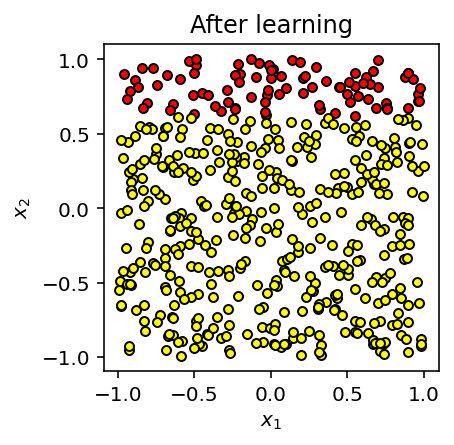

--------------------------------------
Starting Learning with 3 layer(s)!
Starting Epoch 1, learning rate: 0.05
Epoch 1, Loss: 0.553, Accuracy: 0.484
Starting Epoch 2, learning rate: 0.05
Epoch 2, Loss: 0.539, Accuracy: 0.542
Starting Epoch 3, learning rate: 0.05
Epoch 3, Loss: 0.515, Accuracy: 0.550
Starting Epoch 4, learning rate: 0.05
Epoch 4, Loss: 0.469, Accuracy: 0.594
Starting Epoch 5, learning rate: 0.05
Epoch 5, Loss: 0.435, Accuracy: 0.638
Starting Epoch 6, learning rate: 0.05
Epoch 6, Loss: 0.436, Accuracy: 0.618
Starting Epoch 7, learning rate: 0.05
Epoch 7, Loss: 0.433, Accuracy: 0.622
Starting Epoch 8, learning rate: 0.05
Epoch 8, Loss: 0.434, Accuracy: 0.646
Starting Epoch 9, learning rate: 0.05
Epoch 9, Loss: 0.432, Accuracy: 0.616
Starting Epoch 10, learning rate: 0.05
Epoch 10, Loss: 0.433, Accuracy: 0.642
Starting Epoch 11, learning rate: 0.05
Epoch 11, Loss: 0.441, Accuracy: 0.604
Starting Epoch 12, learning rate: 0.05
Epoch 12, Loss: 0.432, Accuracy: 0.622
Starting

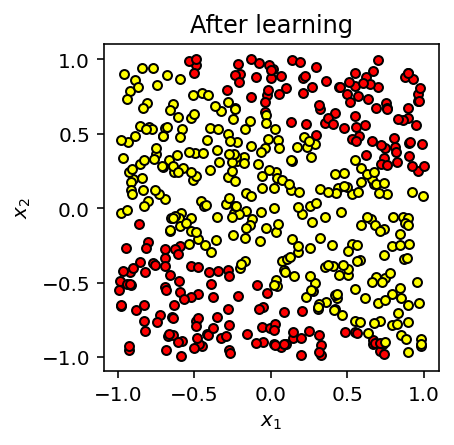

--------------------------------------
Starting Learning with 4 layer(s)!
Starting Epoch 1, learning rate: 0.05
Epoch 1, Loss: 0.483, Accuracy: 0.668
Starting Epoch 2, learning rate: 0.05
Epoch 2, Loss: 0.437, Accuracy: 0.674
Starting Epoch 3, learning rate: 0.05
Epoch 3, Loss: 0.422, Accuracy: 0.722
Starting Epoch 4, learning rate: 0.05
Epoch 4, Loss: 0.407, Accuracy: 0.724
Starting Epoch 5, learning rate: 0.05
Epoch 5, Loss: 0.403, Accuracy: 0.742
Starting Epoch 6, learning rate: 0.05
Epoch 6, Loss: 0.396, Accuracy: 0.766
Starting Epoch 7, learning rate: 0.05
Epoch 7, Loss: 0.395, Accuracy: 0.750
Starting Epoch 8, learning rate: 0.05
Epoch 8, Loss: 0.397, Accuracy: 0.750
Starting Epoch 9, learning rate: 0.05
Epoch 9, Loss: 0.396, Accuracy: 0.756
Starting Epoch 10, learning rate: 0.05
Epoch 10, Loss: 0.399, Accuracy: 0.754
Starting Epoch 11, learning rate: 0.05
Epoch 11, Loss: 0.398, Accuracy: 0.746
Starting Epoch 12, learning rate: 0.05
Epoch 12, Loss: 0.395, Accuracy: 0.752
Starting

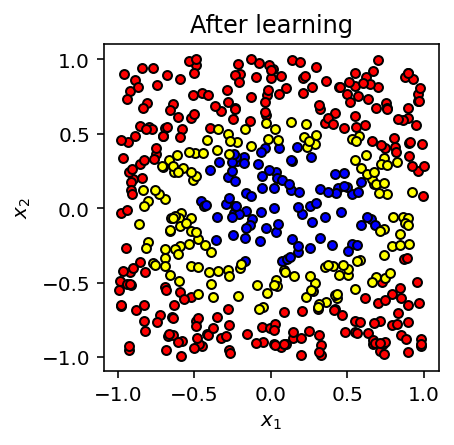

--------------------------------------
Starting Learning with 5 layer(s)!
Starting Epoch 1, learning rate: 0.05
Epoch 1, Loss: 0.500, Accuracy: 0.540
Starting Epoch 2, learning rate: 0.05
Epoch 2, Loss: 0.453, Accuracy: 0.612
Starting Epoch 3, learning rate: 0.05
Epoch 3, Loss: 0.432, Accuracy: 0.600
Starting Epoch 4, learning rate: 0.05
Epoch 4, Loss: 0.427, Accuracy: 0.610
Starting Epoch 5, learning rate: 0.05
Epoch 5, Loss: 0.425, Accuracy: 0.608
Starting Epoch 6, learning rate: 0.05
Epoch 6, Loss: 0.420, Accuracy: 0.614
Starting Epoch 7, learning rate: 0.05
Epoch 7, Loss: 0.424, Accuracy: 0.614
Starting Epoch 8, learning rate: 0.05
Epoch 8, Loss: 0.415, Accuracy: 0.618
Starting Epoch 9, learning rate: 0.05
Epoch 9, Loss: 0.415, Accuracy: 0.618
Starting Epoch 10, learning rate: 0.05
Epoch 10, Loss: 0.414, Accuracy: 0.618
Starting Epoch 11, learning rate: 0.05
Epoch 11, Loss: 0.415, Accuracy: 0.624
Starting Epoch 12, learning rate: 0.05
Epoch 12, Loss: 0.418, Accuracy: 0.622
Starting

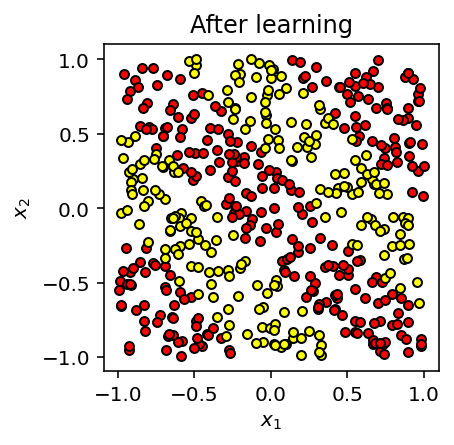

--------------------------------------
Starting Learning with 6 layer(s)!
Starting Epoch 1, learning rate: 0.05
Epoch 1, Loss: 0.418, Accuracy: 0.756
Starting Epoch 2, learning rate: 0.05
Epoch 2, Loss: 0.370, Accuracy: 0.760
Starting Epoch 3, learning rate: 0.05
Epoch 3, Loss: 0.349, Accuracy: 0.778
Starting Epoch 4, learning rate: 0.05
Epoch 4, Loss: 0.340, Accuracy: 0.762
Starting Epoch 5, learning rate: 0.05
Epoch 5, Loss: 0.333, Accuracy: 0.748
Starting Epoch 6, learning rate: 0.05
Epoch 6, Loss: 0.331, Accuracy: 0.754
Starting Epoch 7, learning rate: 0.05
Epoch 7, Loss: 0.331, Accuracy: 0.776
Starting Epoch 8, learning rate: 0.05
Epoch 8, Loss: 0.330, Accuracy: 0.768
Starting Epoch 9, learning rate: 0.05
Epoch 9, Loss: 0.326, Accuracy: 0.768
Starting Epoch 10, learning rate: 0.05
Epoch 10, Loss: 0.325, Accuracy: 0.782
Starting Epoch 11, learning rate: 0.05
Epoch 11, Loss: 0.329, Accuracy: 0.794
Starting Epoch 12, learning rate: 0.05
Epoch 12, Loss: 0.326, Accuracy: 0.766
Starting

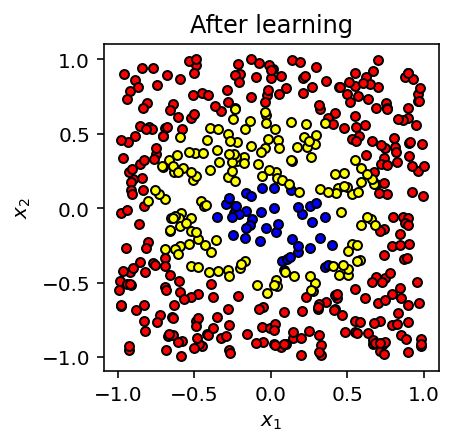

--------------------------------------
Starting Learning with 7 layer(s)!
Starting Epoch 1, learning rate: 0.05
Epoch 1, Loss: 0.501, Accuracy: 0.556
Starting Epoch 2, learning rate: 0.05
Epoch 2, Loss: 0.461, Accuracy: 0.574
Starting Epoch 3, learning rate: 0.05
Epoch 3, Loss: 0.435, Accuracy: 0.650
Starting Epoch 4, learning rate: 0.05
Epoch 4, Loss: 0.411, Accuracy: 0.710
Starting Epoch 5, learning rate: 0.05
Epoch 5, Loss: 0.397, Accuracy: 0.702
Starting Epoch 6, learning rate: 0.05
Epoch 6, Loss: 0.392, Accuracy: 0.692
Starting Epoch 7, learning rate: 0.05
Epoch 7, Loss: 0.387, Accuracy: 0.688
Starting Epoch 8, learning rate: 0.05
Epoch 8, Loss: 0.376, Accuracy: 0.706
Starting Epoch 9, learning rate: 0.05
Epoch 9, Loss: 0.376, Accuracy: 0.716
Starting Epoch 10, learning rate: 0.05
Epoch 10, Loss: 0.365, Accuracy: 0.790
Starting Epoch 11, learning rate: 0.05
Epoch 11, Loss: 0.367, Accuracy: 0.796
Starting Epoch 12, learning rate: 0.05
Epoch 12, Loss: 0.358, Accuracy: 0.804
Starting

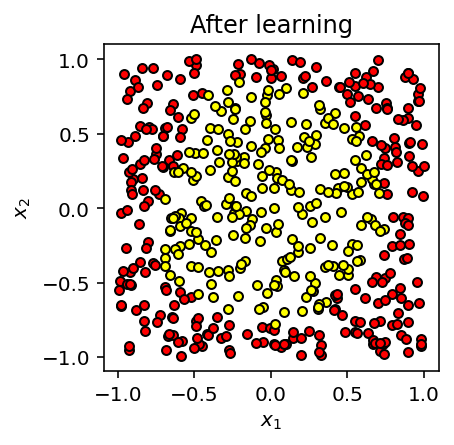

--------------------------------------
Starting Learning with 8 layer(s)!
Starting Epoch 1, learning rate: 0.05
Epoch 1, Loss: 0.467, Accuracy: 0.564
Starting Epoch 2, learning rate: 0.05
Epoch 2, Loss: 0.432, Accuracy: 0.644
Starting Epoch 3, learning rate: 0.05
Epoch 3, Loss: 0.402, Accuracy: 0.708
Starting Epoch 4, learning rate: 0.05
Epoch 4, Loss: 0.369, Accuracy: 0.722
Starting Epoch 5, learning rate: 0.05
Epoch 5, Loss: 0.352, Accuracy: 0.732
Starting Epoch 6, learning rate: 0.05
Epoch 6, Loss: 0.344, Accuracy: 0.754
Starting Epoch 7, learning rate: 0.05
Epoch 7, Loss: 0.335, Accuracy: 0.764
Starting Epoch 8, learning rate: 0.05
Epoch 8, Loss: 0.328, Accuracy: 0.780
Starting Epoch 9, learning rate: 0.05
Epoch 9, Loss: 0.323, Accuracy: 0.784
Starting Epoch 10, learning rate: 0.05
Epoch 10, Loss: 0.316, Accuracy: 0.786
Starting Epoch 11, learning rate: 0.05
Epoch 11, Loss: 0.309, Accuracy: 0.796
Starting Epoch 12, learning rate: 0.05
Epoch 12, Loss: 0.305, Accuracy: 0.832
Starting

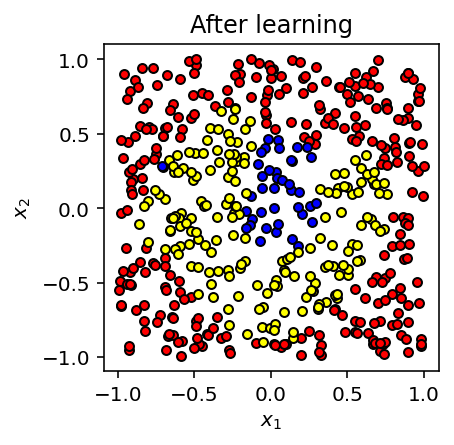

--------------------------------------
Starting Learning with 9 layer(s)!
Starting Epoch 1, learning rate: 0.05
Epoch 1, Loss: 0.548, Accuracy: 0.498
Starting Epoch 2, learning rate: 0.05
Epoch 2, Loss: 0.483, Accuracy: 0.582
Starting Epoch 3, learning rate: 0.05
Epoch 3, Loss: 0.431, Accuracy: 0.706
Starting Epoch 4, learning rate: 0.05
Epoch 4, Loss: 0.392, Accuracy: 0.778
Starting Epoch 5, learning rate: 0.05
Epoch 5, Loss: 0.364, Accuracy: 0.848
Starting Epoch 6, learning rate: 0.05
Epoch 6, Loss: 0.352, Accuracy: 0.874
Starting Epoch 7, learning rate: 0.05
Epoch 7, Loss: 0.346, Accuracy: 0.876
Starting Epoch 8, learning rate: 0.05
Epoch 8, Loss: 0.338, Accuracy: 0.862
Starting Epoch 9, learning rate: 0.05
Epoch 9, Loss: 0.342, Accuracy: 0.850
Starting Epoch 10, learning rate: 0.05
Epoch 10, Loss: 0.324, Accuracy: 0.890
Starting Epoch 11, learning rate: 0.05
Epoch 11, Loss: 0.312, Accuracy: 0.884
Starting Epoch 12, learning rate: 0.05
Epoch 12, Loss: 0.294, Accuracy: 0.886
Starting

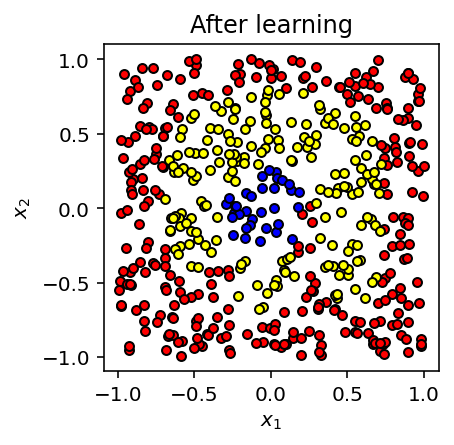

In [14]:
np.random.seed(2)
num_layers_list = [2, 3, 4, 5, 6, 7, 8, 9]


for num_layer in num_layers_list:
    print("--------------------------------------")
    print(f"Starting Learning with {num_layer} layer(s)!")

    params = np.random.uniform(size=(num_layer, num_params))*np.pi/2


    pred_pre = vmap_test(params, train_x, state_labels=state_labels_flat)
    pred_pre = np.array(pred_pre)
    pred_pre = np.array(pred_pre)
    for n, prediction in enumerate(pred_pre):
        pred_pre[n] = state_labels_flat[prediction]

    

    beta=0

    losses = []
    train_acc = []
    param_list = []

    epochs = 40

    learning_rate = 0.05
    opt = AdamOptimizer(learning_rate)

    for i in range(epochs):
        #print("--------------------------------------")
        print(f"Starting Epoch {i+1}, learning rate: {learning_rate:.2f}")

        x_train, y_train = shuffle(train_x, train_y)
        for X_Batch, Y_Batch in iterate_minibatches(x_train, y_train, batch_size):
            #print(X_Batch.shape, Y_Batch.shape)
            params = opt.step(vmap_cost, params, grad_fn=cost_circ_grad, X_batched=X_Batch, y_batched=Y_Batch)
        param_list.append(params)
        pred_test = vmap_test(params, test_x, state_labels_flat)
        pred_test = np.array(pred_test)
        for n, prediction in enumerate(pred_test):
            pred_test[n] = used_labels_arr[prediction]
        acc = accuracy_score(test_y, pred_test)
        loss = vmap_cost(params, train_x, train_y)


        losses.append(loss)
        train_acc.append(acc)
        print(f"Epoch {i+1}, Loss: {loss:.3f}, Accuracy: {acc:.3f}")
        #print(params)
    fig, ax = plt.subplots(1, 1, figsize=(3, 3))
    plot_data(test_x, pred_test, title="After learning", fig=fig, ax=ax)
    plt.show()
    np.save(f"Data_Circle_Squeez/params_{num_layer}-layers-correct_2nd.npy", param_list)
    np.save(f"Data_Circle_Squeez/loss_{num_layer}-layers-correct_2nd.npy", losses)
    np.save(f"Data_Circle_Squeez/acc_{num_layer}-layers-correct_2nd.npy", train_acc)




